In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## Questions

### Question 1

In [2]:
df = pd.read_csv('C:\\Users\\Thobs\\Desktop\\Portfolio\\Projects\\Data-Science-Projects\\ml-zoomcamp-2024\\homeworks\\hw03\\bank_marketing_data\\bank\\bank.csv', delimiter=';')
wanted_cols = ['age', 'job', 'marital', 'education', 'balance', 'housing','contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

df = df[wanted_cols]

# Prepare X and y
X = df.drop('y', axis=1)
y = df['y'].map({'yes': 1, 'no': 0})

# Split the data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1)

# Question 1: ROC AUC feature importance
numerical_columns = ['balance', 'day', 'duration', 'previous']
auc_scores = {}
for col in numerical_columns:
    auc = roc_auc_score(y_train, X_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
    auc_scores[col] = auc

best_feature = max(auc_scores, key=auc_scores.get)
print(f"Q1: The numerical variable with the highest AUC is: {best_feature}")


Q1: The numerical variable with the highest AUC is: duration


### Question 2

In [3]:
# def compute_roc_auc_score(X_train, y_train, X_val, y_val):
dv = DictVectorizer(sparse=False)
train_dict = X_train.to_dict(orient='records')
X_train_encoded = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val_encoded = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f"Q2: AUC on validation set: {val_auc:.3f}")

# y_val_pred = compute_roc_auc_score(X_train, y_train, X_val, y_val)

Q2: AUC on validation set: 0.909


### Question 3

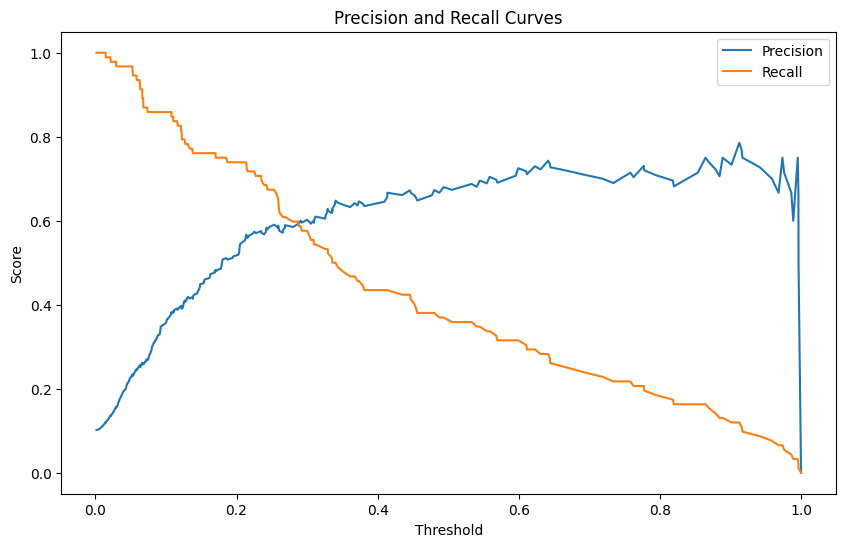

Q3: Precision and recall intersect at threshold: 0.287


In [4]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.show()

# Find intersection
intersection_idx = np.argmin(np.abs(precisions - recalls))
intersection_threshold = thresholds[intersection_idx]
print(f"Q3: Precision and recall intersect at threshold: {intersection_threshold:.3f}")


### Question 4

In [5]:
f1_scores = []
for threshold in np.arange(0, 1.01, 0.01):
    y_pred = (y_val_pred >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

max_f1_threshold = np.arange(0, 1.01, 0.01)[np.argmax(f1_scores)]
print(f"Q4: F1 score is maximal at threshold: {max_f1_threshold:.2f}")

Q4: F1 score is maximal at threshold: 0.22


### Question 5

In [6]:

kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(model, X_train_encoded, y_train, cv=kf, scoring='roc_auc')
print(f"Q5: Standard deviation of scores: {scores.std():.3f}")

Q5: Standard deviation of scores: 0.008


### Question 6

In [7]:
C_values = [0.000001, 0.001, 1]
results = []
def hyperparameter_tuning(C_values)-> None:
    for C in C_values:
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        scores = cross_val_score(model, X_train_encoded, y_train, cv=kf, scoring='roc_auc')
        results.append((C, scores.mean(), scores.std()))

    best_C = max(results, key=lambda x: (x[1], -x[2], -x[0]))
    print(f"Q6: Best C value: {best_C[0]}, Mean score: {best_C[1]:.3f}, Std: {best_C[2]:.3f}")

hyperparameter_tuning(C_values)

Q6: Best C value: 1, Mean score: 0.884, Std: 0.008
